In [195]:
##########
#  Owain Pill Code

from scipy import stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

class ModelSummary:
    """ This class extracts a summary of the model
    
    Methods
    -------
    get_se()
        computes standard error
    get_ci(SE_est)
        computes confidence intervals
    get_pvals()
        computes p-values
    get_summary(name=None)
        prints the summary of the model
    """
    
    def __init__(self, clf, X, y):
        """
        Parameters
        ----------
        clf: class
            the classifier object model
        X: pandas Dataframe
            matrix of predictors
        y: numpy array
            matrix of variable
        """
        self.clf = clf
        self.X = X
        self.y = y
        pass
    
    def get_se(self):
        # from here https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients
        predProbs = self.clf.predict_proba(self.X)
        X_design = np.hstack([np.ones((self.X.shape[0], 1)), self.X])
        V = np.diagflat(np.product(predProbs, axis=1))
        covLogit = np.linalg.inv(np.dot(np.dot(X_design.T, V), X_design))
        return np.sqrt(np.diag(covLogit))

    def get_ci(self, SE_est):
        """
        Parameters
        ----------
        SE_est: numpy array
            matrix of standard error estimations
        """
        p = 0.975
        df = len(self.X) - 2
        crit_t_value = stats.t.ppf(p, df)
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        upper = coefs + (crit_t_value * SE_est)
        lower = coefs - (crit_t_value * SE_est)
        cis = np.zeros((len(coefs), 2))
        cis[:,0] = lower
        cis[:,1] = upper
        return cis
    
    def get_pvals(self):
        # from here https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
        p = self.clf.predict_proba(self.X)
        n = len(p)
        m = len(self.clf.coef_[0]) + 1
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        se = self.get_se()
        t =  coefs/se  
        p = (1 - stats.norm.cdf(abs(t))) * 2
        return p
    
    def get_summary(self, names=None):
        ses = self.get_se()
        cis = self.get_ci(ses)
        lower = cis[:, 0]
        upper = cis[:, 1]
        pvals = self.get_pvals()
        coefs = np.concatenate([self.clf.intercept_, self.clf.coef_[0]])
        data = []
        for i in range(len(coefs)):
            currlist = []
            currlist.append(np.round(coefs[i], 3))
            currlist.append(np.round(ses[i], 3))
            currlist.append(np.round(pvals[i], 3))
            currlist.append(np.round(lower[i], 3))
            currlist.append(np.round(upper[i], 3))
            data.append(currlist)
        cols = ['coefficient', 'std', 'p-value', '[0.025', '0.975]']
        sumdf = pd.DataFrame(columns=cols, data=data)
        if names is not None:
            new_names = ['intercept']*(len(names) + 1)
            new_names[1:] = [i for i in names]
            sumdf.index = new_names
        else:
            try:
                names = list(self.X.columns)
                new_names = ['intercept']*(len(names) + 1)
                new_names[1:] = [i for i in names]
                sumdf.index = new_names
            except:
                pass
        print(sumdf)
        acc = accuracy_score(self.y, self.clf.predict(self.X))
        confmat = confusion_matrix(self.y, self.clf.predict(self.X))
        print('-'*60)
        print('Confusion Matrix (total:{}) \t Accuracy: \t  {}'.format(len(self.X),np.round(acc, 3)))
        print('  TP: {} | FN: {}'.format(confmat[1][1],confmat[1][0]))
        print('  FP: {} | TN: {}'.format(confmat[0][1],confmat[0][0]))


In [196]:
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # prevents future version warnings

#read csv and remove first column which is constituency name
brexit = pd.read_csv('brexit1.csv')
list_cols = list(brexit)[1:]
#print(list_cols)

interest_column = 'Brexit'
interest_column_binary = interest_column + ' binary'

#set threshhold and convert to binary
brexit[interest_column_binary] = brexit[interest_column] > 0.5
brexit[interest_column_binary] = brexit[interest_column_binary].astype(int)

print(brexit[interest_column].median())
print(len(brexit[brexit[interest_column_binary] == 0]))

#undersample majority in this case
#voted_leave = brexit.loc[brexit[interest_column_binary] == 1].sample(172)
#brexit = pd.concat((brexit.loc[brexit[interest_column_binary] == 0], voted_leave))

#print(brexit[interest_column_binary])
#print(len(voted_leave))


col_list = list_cols[5:20]#['CON%Lev_4_qual', 'gh']

#test with just the highest r2 variable
X = brexit['CON%Lev_4_qual'].values.reshape(-1,1)
y = brexit['Brexit binary'].values.reshape(-1,1)

mylr = logreg()
mylr.fit(X,y)

model_summary = ModelSummary(mylr,X,y)
model_summary.get_summary()

0.55
172
   coefficient    std  p-value  [0.025  0.975]
0       11.158  0.998      0.0   9.196  13.119
1       -0.367  0.034      0.0  -0.434  -0.299
------------------------------------------------------------
Confusion Matrix (total:533) 	 Accuracy: 	  0.865
  TP: 335 | FN: 26
  FP: 46 | TN: 126


In [197]:
#splitting columns into train validate and test

from sklearn.model_selection import train_test_split

#split into train validate test, 0.5,0.25,0.25
train, other = train_test_split(brexit, test_size=0.5, random_state=None)

validation, test = train_test_split(other, test_size=0.5, random_state=None)

#random_state=0 default here

#get rid of columns that are not useful
for df in [brexit, train, validation, test]:
    del df['Constituency']
    del df['Brexit']
    del df['Brexit Predicted']
    del df['Conservative Votes']
    del df['Labour Votes']
    del df['Lib Dem Votes']
    

#create the X and y by dropping or keeping columns
X_train = train.drop(columns=[interest_column_binary])
y_train = train[interest_column_binary]

X_val = validation.drop(columns=[interest_column_binary])
y_val = validation[interest_column_binary]

X_test = test.drop(columns=[interest_column_binary])
y_test = test[interest_column_binary]

#save a clean version for the very end
X_train_final = train.drop(columns=[interest_column_binary])
y_train_final = train[interest_column_binary]

X_val_final = validation.drop(columns=[interest_column_binary])
y_val_final = validation[interest_column_binary]

X_test_final = test.drop(columns=[interest_column_binary])
y_test_final = test[interest_column_binary]

print(len(X_train))
print(len(X_val))
print(len(X_test))

266
133
134


In [198]:
#cols in order of r2 value
r2order_cols = ['CON%Lev_4_qual', 'CON%PROF', 'CON%Lev_1_qual', 'CON%L_SUP_TECH', 'CON%SEMI', 'CON%PROF_SCI_TECH', 'CON%Lev_2_qual', 'vgh', 'CON%OPS', 'CON%SKILL', 'CON%H_PROF', 'CON%No_qual', 'fh', 'CON%INF_COM', 'CON%ROUT', 'CON%CONST', 'CON%ASSOC_PROF_TECH', 'High blood pressure (hypertension)', 'Epilepsy', 'CON%WT_RT_REPM', 'Obesity', 'CON%H_MAN_AD_PROF', 'CON%Appren', 'Rheumatoid arthritis', 'CON%MANF', 'CON%AC_EMP_E_P', 'COPD', 'Coronary heart disease', 'Median House Price', 'CON%OTHER', 'Diabetes', 'CON%Private_r_land', 'Ratio of median house price to median salary', 'CON%Private_rent', 'CON%CAR_LEI_', '"Mixed"', 'CON%W_SEW_WAST_REM', 'CON%INA_RET', 'CON%1_fm', 'gh', '"Other"', 'Peripheral arterial disease', 'Stroke and transient ischaemic attack', 'CON%REAL', 'Chronic kidney disease', 'CON%NO_ADEM_NCHILD', 'CON%INA_STUD', 'Standardised Weighted Overall Social Mobility Index', 'CON%NO_ADEM', 'Asthma', 'CON%NON_C', 'CON%FT_STUD', 'Heart failure', 'CON%L_MAN_AD_PROF', '60-69', 'CON%1_ps_Oth', 'Are Christian (proportion)', 'Home Ownership (proportion of households)', 'CON%Own', '"Black"', '30-39', '50-59', 'Learning disabilities', '70-79', 'Dementia', 'bh', 'CON%EDUC', 'Cardiovascular disease (primary prevention)', 'Depression', 'CON%1_ps_65', 'Atrial fibrillation', 'CON%AC_F_STUD', '"White"', 'CON%Own_mort', '20-29', 'Labour Votes', 'CON%ELEM', 'CON%FIN_INS', 'CON%I_OCC', 'Number of Businesses', 'CON%Own_out', 'CON%NO', 'CON%UN_16_24', 'CON%TRAN_STOR', 'Conservative Vote (proportion)', 'CON%Share', 'Labour Vote (proportion)', 'CON%SAL_SERV', 'Cancer diagnosis since 2003', 'CON%Oth_qual', 'Turnout (Proportion)', 'CON%1CV', '80+', 'Number of businesses per capita', 'CON%AC_SELF', 'CON%MAN_DIR_SEN', 'Schizophrenia, bipolar disorder & psychoses', 'CON%2CV', 'CON%LG_E_H_MAN_AD', 'vbh', 'Conservative Votes', 'Lib Dem Votes', 'Lib Dem Vote (proportion)', 'CON%INA_LONG SICK', 'CON%E_G_S_AIR', 'CON%1_ps', 'Are Muslim (proportion)', 'CON%3CV', 'CON%Soc_r_Other', '40-49', 'CON%ADMIN_SEC', '"Asian"', 'CON%ACCOM_FOOD', 'CON%UN_50_74', 'Electorate', 'Share of LSOAs (small areas) in most deprived decile', 'Unemployment Rate', 'CON%AC_ALL', 'CON%INA_ALL', 'CON%4+CV', 'CON%INA_OTHER', 'CON%HEAL_SOC', 'Average Internet Speed (Mb/s)', 'CON%Soc_r', 'Are Religous (proportion)', 'CON%A_FOR_FISH', 'CON%Lev_3_qual', 'CON%ADMIN_SUPP', 'CON%ADMIN_DEF', 'CON%M_Q', 'CON%UN_LONG', 'CON%L_EMP', 'CON%Private_r_Oth', 'CON%AC_EMP_E_F', 'CON%N_WKD', 'CON%AC_UNE', 'CON%S_EMP_OWN', 'Are Not Religious (proportion)', 'CON%Rent_free', 'CON%N_WKD_L_EMP', 'CON%1_fm_lp_dc', 'CON%AC_EMP', 'CON%INA_CARE', '19-Oct', '0-9', 'CON%Soc_r_LA', 'CON%NO_ADEM_WCHILD', 'School Funding Per Pupil (Real)', 'CON%UN_NEVER', 'Osteoporosis']


(1, 40)

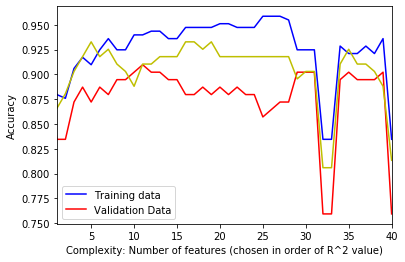

In [199]:

##ORDERED SELECTOR

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

#initialise lists for graphs 
train_accuracy = []
validation_accuracy = []
test_accuracy = []

#set range of number of columns to try
lower_range = 1
upper_range = 40
#hacky way of getting the right ranges to show up
for i in range(lower_range):
    train_accuracy.append(0.9)
    validation_accuracy.append(0.9)
    test_accuracy.append(0.9)
    

#select first i columns from ordered columns to train and validate model and graph
for i in range(lower_range, upper_range+1):
    #print(i)
    selected_columns = r2order_cols[0:i]
    #print(selected_columns)
    model = LogisticRegression(C=1e9).fit(X_train[selected_columns], y_train)

    y_train_predicted = model.predict(X_train[selected_columns])
    y_val_predicted = model.predict(X_val[selected_columns])
    y_test_predicted = model.predict(X_test[selected_columns])
    #print(len(X_test[selected_columns]))
    
    train_accuracy.append(accuracy_score(y_train, y_train_predicted))
    validation_accuracy.append(accuracy_score(y_val, y_val_predicted))
    test_accuracy.append(accuracy_score(y_test, y_test_predicted))
'''
    print('======= Accuracy  table =======')
    print('Training accuracy is:    {}'.format(accuracy_score(y_train, y_train_predicted)))
    print('Validation accuracy is:  {}'.format(accuracy_score(y_val, y_val_predicted)))
    print('Test accuracy is:  {}'.format(accuracy_score(y_test, y_test_predicted)))
'''

#plot everything
plt.figure()
#plt.set_xlim(xmin=lower_range, xmax=upper_range)
#fig, ax = plt.subplots()

plt.plot(train_accuracy,'b')
#fig.plot(train_accuracy,'b')
plt.plot(validation_accuracy,'r')
plt.plot(test_accuracy,'y')
plt.legend(['Training data', 'Validation Data'])
plt.xlabel('Complexity: Number of features (chosen in order of R^2 value)')
plt.ylabel('Accuracy')
plt.locator_params(axis="both", integer=True, tight=True)
#fig, ax = plt.subplots()
plt.xlim((lower_range,upper_range))
#plt.ylim((0.7,1))


(1, 40)

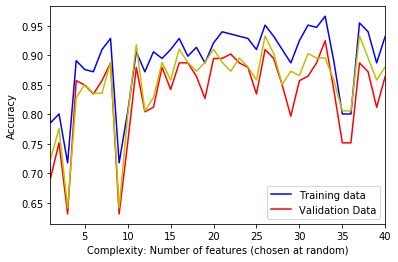

In [200]:
##RANDOM SELECTOR - same as r2cols except with random


train_accuracy = []
validation_accuracy = []
test_accuracy = []


#X_train_noconst = X_train.drop(columns=['Constituency'])

lower_range = 1
upper_range = 40
#hacky way of getting the right ranges to show up
for i in range(lower_range):
    train_accuracy.append(0.9)
    validation_accuracy.append(0.9)
    test_accuracy.append(0.9)
    
    

for i in range(lower_range,upper_range+1):
    #print(i)
    X_train_cols = X_train.sample(n=i,axis='columns')#method that returns random columns
    #print(len(list(X_train)))
    selected_columns = list(X_train_cols)
    #print(selected_columns)
    model = LogisticRegression(C=1e9).fit(X_train[selected_columns], y_train)

    y_train_predicted = model.predict(X_train[selected_columns])
    y_val_predicted = model.predict(X_val[selected_columns])
    y_test_predicted = model.predict(X_test[selected_columns])
    #print(len(X_test[selected_columns]))
    
    train_accuracy.append(accuracy_score(y_train, y_train_predicted))
    validation_accuracy.append(accuracy_score(y_val, y_val_predicted))
    test_accuracy.append(accuracy_score(y_test, y_test_predicted))
    '''
    print('======= Accuracy  table =======')
    print('Training accuracy is:    {}'.format(accuracy_score(y_train, y_train_predicted)))
    print('Validation accuracy is:  {}'.format(accuracy_score(y_val, y_val_predicted)))
    print('Test accuracy is:  {}'.format(accuracy_score(y_test, y_test_predicted)))
    '''
plt.figure()
#plt.set_xlim(xmin=lower_range, xmax=upper_range)
#fig, ax = plt.subplots()

plt.plot(train_accuracy,'b')
#fig.plot(train_accuracy,'b')
plt.plot(validation_accuracy,'r')
plt.plot(test_accuracy,'y')
plt.legend(['Training data', 'Validation Data'])
plt.xlabel('Complexity: Number of features (chosen at random)')
plt.ylabel('Accuracy')
plt.locator_params(axis="both", integer=True, tight=True)
#fig, ax = plt.subplots()
plt.xlim((lower_range,upper_range))
#plt.ylim((0.7,1))

In [201]:
#########FORWARD SELECTION

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

#forward selection
train_accuracy = []
validation_accuracy = []
test_accuracy = []

def select_column_to_add(X_train, y_train, X_val, y_val, columns_in_model, columns_to_test):
    
    column_best = None
    columns_in_model = list(columns_in_model)
    
    if len(columns_in_model) == 0:
        acc_best = 0
    elif len(columns_in_model) == 1:
        mod = LogisticRegression(C=1e9).fit(X_train[columns_in_model].values.reshape(-1, 1), y_train)
        acc_best = accuracy_score(y_val, mod.predict(X_val[columns_in_model].values.reshape(-1, 1)))/2
    else:
        mod = LogisticRegression(C=1e9).fit(X_train[columns_in_model], y_train)
        acc_best = accuracy_score(y_val, mod.predict(X_val[columns_in_model]))/2
        #divide by 2 to allow as many columns as specified - acc for first column added will always be greater

    
    for column in columns_to_test:
        #print(column)
        mod = LogisticRegression(C=1e9).fit(X_train[columns_in_model+[column]], y_train)
        y_pred_val = mod.predict(X_val[columns_in_model+[column]])
        y_pred_train = mod.predict(X_train[columns_in_model+[column]])
        #acc = accuracy_score(y_val, y_pred_val)*2 + accuracy_score(y_train, y_pred_train)
        #acc = acc/2
        acc = accuracy_score(y_val, y_pred_val)
        
        #if acc - acc_best >= 0.005:  # one of our stopping criteria
        if acc >= acc_best + 0.005:
            #print(acc)
            acc_best = acc
            column_best = column
        
    if column_best is not None:  # the other stopping criteria
        print('Adding {} to the model'.format(column_best))
        print('The new best validation accuracy is {}'.format(acc_best))
        columns_in_model_updated = columns_in_model + [column_best]
        #print(columns_in_model_updated)
        #add to graphs
        mod = LogisticRegression(C=1e9).fit(X_train[columns_in_model+[column]], y_train)
        y_pred_val = mod.predict(X_val[columns_in_model+[column]])
        y_pred_train = mod.predict(X_train[columns_in_model+[column]])
        train_accuracy.append(accuracy_score(y_train, y_pred_train))
        validation_accuracy.append(accuracy_score(y_val, y_pred_val))
        #print(train_accuracy)

    else:
        print('Did not add anything to the model')
        columns_in_model_updated = columns_in_model
    
    return columns_in_model_updated, acc_best



####Forward selector itself

def auto_forward_selection(X_train, y_train, X_val, y_val, max_num_features):
    
    columns_to_test = list(X_train.columns)
    columns_in_model = []
    current_acc = 0
    same_acc_buffer = 0
    
    for i in range(0, max_num_features):
        columns_in_model, acc_best = select_column_to_add(X_train, y_train, X_val, y_val, columns_in_model, columns_to_test)
        if acc_best <= current_acc:
            same_acc_buffer+=1
            columns_in_model = columns_in_model[1:]
            print('Worse')
        else:
            for feature in columns_to_test:
                if feature in columns_in_model:
                    columns_to_test.remove(feature)
        if same_acc_buffer == 4:
            break
                    
    print(columns_in_model, acc_best)
    return columns_in_model


test1 = auto_forward_selection(X_train, y_train, X_val, y_val, 5)#30

selected_columns = test1

print(selected_columns)

#selected_columns = ['CON%L_SUP_TECH', 'Conservative Vote (proportion)', 'CON%H_MAN_AD_PROF']

model = LogisticRegression(penalty='l1',C=1e9, solver='liblinear').fit(X_train[selected_columns], y_train)#default C=1e9 only

y_train_predicted = model.predict(X_train[selected_columns])
y_val_predicted = model.predict(X_val[selected_columns])
y_test_predicted = model.predict(X_test[selected_columns])
#print(len(X_test[selected_columns]))
'''
train_accuracy.append(accuracy_score(y_train, y_train_predicted))
validation_accuracy.append(accuracy_score(y_val, y_val_predicted))
test_accuracy.append(accuracy_score(y_test, y_test_predicted))
'''

print('======= Accuracy  table =======')
print('Training accuracy is:    {}'.format(accuracy_score(y_train, y_train_predicted)))
print('Validation accuracy is:  {}'.format(accuracy_score(y_val, y_val_predicted)))
print('Test accuracy is:  {}'.format(accuracy_score(y_test, y_test_predicted)))

Adding CON%Lev_1_qual to the model
The new best validation accuracy is 0.8571428571428571
Adding vgh to the model
The new best validation accuracy is 0.9022556390977443
Adding Conservative Vote (proportion) to the model
The new best validation accuracy is 0.9097744360902256
Adding CON%WT_RT_REPM to the model
The new best validation accuracy is 0.924812030075188
Adding Labour Vote (proportion) to the model
The new best validation accuracy is 0.9323308270676691
['CON%Lev_1_qual', 'vgh', 'Conservative Vote (proportion)', 'CON%WT_RT_REPM', 'Labour Vote (proportion)'] 0.9323308270676691
['CON%Lev_1_qual', 'vgh', 'Conservative Vote (proportion)', 'CON%WT_RT_REPM', 'Labour Vote (proportion)']
======= Accuracy  table =======
Training accuracy is:    0.9323308270676691
Validation accuracy is:  0.924812030075188
Test accuracy is:  0.9104477611940298


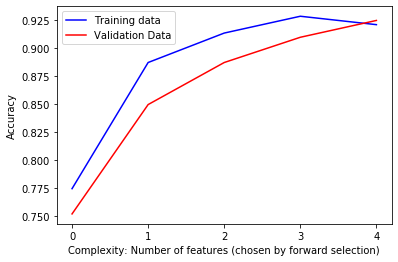

In [202]:
#one step out with the others
test_accuracy = test_accuracy[1:]

#print(train_accuracy)
plt.figure()
#plt.set_xlim(xmin=lower_range, xmax=upper_range)
#fig, ax = plt.subplots()

plt.plot(train_accuracy,'b')
#fig.plot(train_accuracy,'b')
plt.plot(validation_accuracy,'r')
plt.plot(test_accuracy,'y')
plt.legend(['Training data', 'Validation Data'])
plt.xlabel('Complexity: Number of features (chosen by forward selection)')
plt.ylabel('Accuracy')
plt.locator_params(axis="both", integer=True, tight=True)
#fig, ax = plt.subplots()
#plt.xlim((lower_range,upper_range))
#plt.ylim((0.7,1))

In [203]:
####Model summary for chosen forward logistic regression

model = LogisticRegression(C=1e9).fit(X_train[selected_columns], y_train)#penalty='l1',C=1e9, solver='liblinear'

X = X_train[selected_columns]
y = y_train

model_summary = ModelSummary(model,X,y)
model_summary.get_summary()

                                coefficient    std  p-value  [0.025  0.975]
intercept                            16.688  8.720    0.056  -0.481  33.857
CON%Lev_1_qual                        1.074  0.246    0.000   0.589   1.559
vgh                                  -0.688  0.152    0.000  -0.987  -0.388
Conservative Vote (proportion)        6.322  3.377    0.061  -0.328  12.971
CON%WT_RT_REPM                        0.186  0.165    0.260  -0.140   0.512
Labour Vote (proportion)             -8.501  3.376    0.012 -15.149  -1.853
------------------------------------------------------------
Confusion Matrix (total:266) 	 Accuracy: 	  0.932
  TP: 186 | FN: 5
  FP: 13 | TN: 62


In [204]:
######LASSO To avoid too many features
X_train_standardised = (X_train)

for df in [X_train, X_val, X_test]:
    for col in df.columns:
        #print(df[col])
        #print((df[col]-df[col].mean())/df[col].std())
        df[col] = (df[col]-df[col].mean())/df[col].std()
        
#print(X_train.head)

####Model summary for chosen forward logistic regression WITH PENALTY

model = LogisticRegression(penalty='l1',C=0.1, solver='liblinear').fit(X_train[selected_columns], y_train)

X = X_train[selected_columns]
y = y_train

model_summary = ModelSummary(model,X,y)
model_summary.get_summary()

#get pvalues from model summary 
ps = model_summary.get_pvals()[1:]
ps = list(ps)
#print(ps)
#print(list(model_summary.X))
col_names_final = list(model_summary.X)

#print(np.where(ps = 1))

#indices of where p value is 1
indices1 = [i for i, x in enumerate(ps) if x == 1]#x==1
print(indices1)

#remove columns where p value is too high
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            #print(idx)
            list_object.pop(idx)

delete_multiple_element(col_names_final, indices1)

print(col_names_final)

                                coefficient    std  p-value  [0.025  0.975]
intercept                             1.023  0.183    0.000   0.662   1.383
CON%Lev_1_qual                        1.273  0.301    0.000   0.679   1.866
vgh                                  -0.931  0.279    0.001  -1.481  -0.380
Conservative Vote (proportion)        0.163  0.270    0.546  -0.369   0.695
CON%WT_RT_REPM                        0.098  0.250    0.696  -0.395   0.591
Labour Vote (proportion)             -0.318  0.256    0.215  -0.823   0.187
------------------------------------------------------------
Confusion Matrix (total:266) 	 Accuracy: 	  0.921
  TP: 186 | FN: 5
  FP: 16 | TN: 59
[]
['CON%Lev_1_qual', 'vgh', 'Conservative Vote (proportion)', 'CON%WT_RT_REPM', 'Labour Vote (proportion)']


In [205]:
#FINAL MODEL Results
#['CON%L_SUP_TECH', 'CON%Lev_4_qual', 'Conservative Vote (proportion)', 'High blood pressure (hypertension)']

selected_columns = col_names_final
selected_columns = ['CON%Lev_4_qual', 'Conservative Vote (proportion)', 'High blood pressure (hypertension)']
#print(selected_columns)
model = LogisticRegression(C=1e9).fit(X_train_final[selected_columns], y_train_final)

#print(X_train_final.head())

y_train_predicted = model.predict(X_train_final[selected_columns])
y_val_predicted = model.predict(X_val_final[selected_columns])
y_test_predicted = model.predict(X_test_final[selected_columns])
#print(len(X_test[selected_columns]))

print('======= Accuracy  table =======')
print('Training accuracy is:    {}'.format(accuracy_score(y_train_final, y_train_predicted)))
print('Validation accuracy is:  {}'.format(accuracy_score(y_val_final, y_val_predicted)))
print('Test accuracy is:  {}'.format(accuracy_score(y_test_final, y_test_predicted)))


======= Accuracy  table =======
Training accuracy is:    0.9285714285714286
Validation accuracy is:  0.9172932330827067
Test accuracy is:  0.917910447761194


In [206]:

X = X_train_final[selected_columns]
y = y_train_final

model_summary = ModelSummary(model,X,y)
model_summary.get_summary()


# end of Owain Pill Code
##############################################

                                    coefficient     std  p-value  [0.025  \
intercept                                 4.336   2.565    0.091  -0.713   
CON%Lev_4_qual                           -0.499   0.085    0.000  -0.665   
Conservative Vote (proportion)           13.639   3.563    0.000   6.624   
High blood pressure (hypertension)       43.613  15.160    0.004  13.763   

                                    0.975]  
intercept                            9.386  
CON%Lev_4_qual                      -0.332  
Conservative Vote (proportion)      20.655  
High blood pressure (hypertension)  73.463  
------------------------------------------------------------
Confusion Matrix (total:266) 	 Accuracy: 	  0.929
  TP: 185 | FN: 6
  FP: 13 | TN: 62
